In [ ]:
# # Param
# test = "True"

In [2]:
is_test = True
if test == "False" or test == False:
    is_test = False

In [3]:
dataset = "data"

In [4]:
from utils.data_loader import DataLoader
from utils.data_io import join_path

In [5]:
data_loader = DataLoader(dataset)

In [6]:
train_df = data_loader.get_data_train()
test_df = data_loader.get_data_test()

In [7]:
data_desc = data_loader.get_data_desc()

label_column = data_desc['label_column']
text_column = data_desc['text_column']

In [8]:
keyword_concepts = data_loader.get_keyword_concepts()
keywords = []
for k in keyword_concepts.keys():
    keywords += keyword_concepts[k]

print(keywords)

['coronary', 'hypertension', 'systolic', 'diastolic', 'stenosis', 'cirrhosis', 'hepatitis', 'dysphagia', 'peritonitis', 'liver disease', 'infection', 'cardiac', 'vaginal', 'nervous', 'ocular', 'carcinoma', 'malignancy', 'metastasis', 'tumor', 'cancer', 'neurologic', 'spinal', 'brain', 'sclerosis', 'spasticity']


In [9]:
abstract_concepts = data_loader.get_abstract_concepts()
abstract_concepts = [ac['abstract_concept_name'] for ac in abstract_concepts]
abstract_concepts

['Cardiac Function Impairment',
 'Coronary Artery Disease',
 'Liver Pathologies',
 'Swallowing and Digestive Tract Issues',
 'General Inflammation and Infection',
 'Systemic Conditions',
 'Malignant Growths',
 'Neoplastic Spread and Masses',
 'Central Nervous System Disorders',
 'Neuromuscular and Motor Control Issues']

In [10]:
from sklearn.preprocessing import LabelEncoder

In [11]:
le = LabelEncoder()
le.fit(train_df[label_column])
train_df[label_column] = le.transform(train_df[label_column])
test_df[label_column] = le.transform(test_df[label_column])

In [12]:
labels = list(le.classes_)
labels

['cardiovascular diseases',
 'digestive system diseases',
 'general pathological conditions',
 'neoplasms',
 'nervous system diseases']

In [13]:
if is_test:
    train_df = train_df.groupby(label_column).sample(1)
    test_df = test_df.groupby(label_column).sample(1)

In [14]:
train_texts = train_df[text_column].to_list()
train_labels = train_df[label_column].to_list()
test_texts = test_df[text_column].to_list()
test_labels = test_df[label_column].to_list()

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42)

In [17]:
keyword_nli_model_path = join_path(dataset, 'scorer_model', 'keyword_scorer')
abstract_nli_model_path = join_path(dataset, 'scorer_model', 'abstract_scorer')

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertForSequenceClassification
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import networkx as nx
from matplotlib import cm
from sentence_transformers import SentenceTransformer

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertTokenizer, BertForSequenceClassification
from sentence_transformers import SentenceTransformer


def load_model(path):
    model = BertForSequenceClassification.from_pretrained(path)
    tokenizer = BertTokenizer.from_pretrained(path)
    return model, tokenizer

In [ ]:
import torch
from torch.utils.data import DataLoader as TorchDataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from sentence_transformers import SentenceTransformer
import numpy as np
from tqdm import tqdm

def precompute_nli_scores(texts, concept_names, tokenizer, scorer, device, batch_size=512):
    scorer = scorer.to(device)
    scorer.eval()
    scores = []
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        batch_scores = []
        for cname in concept_names:
            inputs = tokenizer(batch_texts, [cname] * len(batch_texts),
                              return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
            with torch.no_grad():
                outputs = scorer(**inputs)
                probs = torch.softmax(outputs.logits, dim=-1)
                batch_scores.append(probs[:, 1].cpu())  # Entailment scores
        scores.append(torch.stack(batch_scores, dim=1))  # [batch_size, n_concepts]
    return torch.cat(scores, dim=0)  # [n_texts, n_concepts]

# Precompute scores for train, validation, and test sets
device = 'cuda' if torch.cuda.is_available() else 'cpu'
keyword_scorer, keyword_tokenizer = load_model(keyword_nli_model_path)
abstract_scorer, abstract_tokenizer = load_model(abstract_nli_model_path)

train_keyword_scores = precompute_nli_scores(train_texts, keywords, keyword_tokenizer, keyword_scorer, device)
train_abstract_scores = precompute_nli_scores(train_texts, abstract_concepts, abstract_tokenizer, abstract_scorer, device)
val_keyword_scores = precompute_nli_scores(val_texts, keywords, keyword_tokenizer, keyword_scorer, device)
val_abstract_scores = precompute_nli_scores(val_texts, abstract_concepts, abstract_tokenizer, abstract_scorer, device)
test_keyword_scores = precompute_nli_scores(test_texts, keywords, keyword_tokenizer, keyword_scorer, device)
test_abstract_scores = precompute_nli_scores(test_texts, abstract_concepts, abstract_tokenizer, abstract_scorer, device)

In [21]:
class ConceptNetwork(nn.Module):
    def __init__(self, concept_names, embedding_dim):
        super(ConceptNetwork, self).__init__()
        self.embedding_dim = embedding_dim
        self.concept_names = concept_names  # [[keywords], [abstracts], [labels]]
        
        # Embeddings
        self.keyword_embeddings = nn.Parameter(torch.randn(len(concept_names[0]), embedding_dim))
        self.abstract_embeddings = nn.Parameter(torch.randn(len(concept_names[1]), embedding_dim))
        self.label_embeddings = nn.Parameter(torch.randn(len(concept_names[2]), embedding_dim))
        
        # Beta parameters (learnable reliability weights)
        self.keyword_betas = nn.Parameter(torch.zeros(len(concept_names[0])))
        self.abstract_betas = nn.Parameter(torch.zeros(len(concept_names[1])))
        
        # Semantic predictor
        self.semantic_predictor = nn.Linear(embedding_dim, 384)  # SBERT output dim

    def forward(self, keyword_scores, abstract_direct):
        """
        keyword_scores: [B, n_keywords] - Precomputed keyword NLI scores
        abstract_direct: [B, n_abstracts] - Precomputed abstract NLI scores
        Returns: predictions, keyword_semantic, abstract_semantic, label_semantic, keyword_scores, abstract_scores
        """
        # Keyword layer: use precomputed scores
        keyword_scores = keyword_scores  # [B, n_kw]
        
        # Abstract layer: combine direct and relation scores
        attn_kw_abs = torch.matmul(self.keyword_embeddings, self.abstract_embeddings.T)  # [n_kw, n_abs]
        attn_kw_abs = torch.softmax(attn_kw_abs, dim=0)  # Softmax over keywords
        relation_kw_abs = torch.matmul(keyword_scores, attn_kw_abs)  # [B, n_abs]
        
        abstract_betas = torch.sigmoid(self.abstract_betas)  # [n_abs]
        abstract_scores = abstract_direct * abstract_betas + relation_kw_abs * (1 - abstract_betas)  # [B, n_abs]
        
        # Label layer: relation only (abstract → label)
        attn_abs_lbl = torch.matmul(self.abstract_embeddings, self.label_embeddings.T)  # [n_abs, n_lbl]
        attn_abs_lbl = torch.softmax(attn_abs_lbl, dim=0)  # Softmax over abstracts
        predictions = torch.matmul(abstract_scores, attn_abs_lbl)  # [B, n_lbl]
        
        # Semantic predictions
        keyword_semantic = self.semantic_predictor(self.keyword_embeddings)  # [n_kw, 384]
        abstract_semantic = self.semantic_predictor(self.abstract_embeddings)  # [n_abs, 384]
        label_semantic = self.semantic_predictor(self.label_embeddings)  # [n_lbl, 384]
        
        return predictions, keyword_semantic, abstract_semantic, label_semantic, keyword_scores, abstract_scores

In [ ]:
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import TensorDataset, DataLoader as TorchDataLoader

def train_model(model, train_texts, train_labels, train_keyword_scores, train_abstract_scores,
                val_texts, val_labels, val_keyword_scores, val_abstract_scores,
                concept_names, sbert_embeddings, batch_size=32, num_epochs=50,
                patience=5, lambda_semantic=0.1, device='cuda'):
    
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    mse_loss = nn.MSELoss()
    scaler = GradScaler()  # For mixed precision
    
    # Convert SBERT embeddings to tensors
    sbert_tensors = [torch.tensor(arr, device=device, dtype=torch.float32) for arr in sbert_embeddings]
    
    # Create DataLoader
    train_dataset = TensorDataset(
        train_keyword_scores, train_abstract_scores,
        torch.tensor(train_labels, dtype=torch.long)
    )
    train_loader = TorchDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    
    val_dataset = TensorDataset(
        val_keyword_scores, val_abstract_scores,
        torch.tensor(val_labels, dtype=torch.long)
    )
    val_loader = TorchDataLoader(val_dataset, batch_size=batch_size, num_workers=4, pin_memory=True)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for batch_keyword_scores, batch_abstract_scores, batch_labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            batch_keyword_scores = batch_keyword_scores.to(device)
            batch_abstract_scores = batch_abstract_scores.to(device)
            batch_labels = batch_labels.to(device)
            
            optimizer.zero_grad()
            with autocast():  # Mixed precision
                predictions, keyword_semantic, abstract_semantic, label_semantic, _, _ = model(
                    batch_keyword_scores, batch_abstract_scores
                )
                pred_loss = criterion(predictions, batch_labels)
                semantic_loss = sum(mse_loss(emb, sbert_tensors[i]) for i, emb in enumerate(
                    [keyword_semantic, abstract_semantic, label_semantic]
                ))
                total_loss = pred_loss + lambda_semantic * semantic_loss
            
            scaler.scale(total_loss).backward()
            scaler.step(optimizer)
            scaler.update()
            epoch_train_loss += total_loss.item()
        
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_keyword_scores, batch_abstract_scores, batch_labels in val_loader:
                batch_keyword_scores = batch_keyword_scores.to(device)
                batch_abstract_scores = batch_abstract_scores.to(device)
                batch_labels = batch_labels.to(device)
                
                with autocast():
                    predictions, keyword_semantic, abstract_semantic, label_semantic, _, _ = model(
                        batch_keyword_scores, batch_abstract_scores
                    )
                    pred_loss = criterion(predictions, batch_labels)
                    semantic_loss = sum(mse_loss(emb, sbert_tensors[i]) for i, emb in enumerate(
                        [keyword_semantic, abstract_semantic, label_semantic]
                    ))
                    val_loss += (pred_loss + lambda_semantic * semantic_loss).item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
            print("Saved new best model.")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break
    
    # Plot losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.savefig('loss_plot.png')
    plt.close()
    
    return train_losses, val_losses

In [29]:
def test_model(model, test_keyword_scores, test_abstract_scores, test_labels, concept_names, batch_size=32, device='cuda'):
    model = model.to(device)
    model.eval()
    predictions = []
    true_labels = []
    
    test_dataset = TensorDataset(test_keyword_scores, test_abstract_scores, torch.tensor(test_labels, dtype=torch.long))
    test_loader = TorchDataLoader(test_dataset, batch_size=batch_size, num_workers=4, pin_memory=True)
    
    with torch.no_grad():
        for batch_keyword_scores, batch_abstract_scores, batch_labels in tqdm(test_loader, desc="Testing"):
            batch_keyword_scores = batch_keyword_scores.to(device)
            batch_abstract_scores = batch_abstract_scores.to(device)
            
            outputs, _, _, _, _, _ = model(batch_keyword_scores, batch_abstract_scores)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(batch_labels.cpu().numpy())
    
    print("\nClassification Report:")
    print(classification_report(true_labels, predictions, target_names=concept_names[2]))

def interpretable_prediction(model, test_text, test_label, test_keyword_scores, test_abstract_scores, concept_names, device='cuda'):
    model = model.to(device)
    model.eval()
    
    print("\nInterpretable Prediction for Sample:")
    print(f"Input Text: {test_text}")
    print(f"True Label: {concept_names[2][test_label]}")
    
    with torch.no_grad():
        keyword_scores = test_keyword_scores[0:1].to(device)  # [1, n_keywords]
        abstract_direct = test_abstract_scores[0:1].to(device)  # [1, n_abstracts]
        predictions, _, _, _, keyword_scores, abstract_scores = model(keyword_scores, abstract_direct)
        
        print("\nKeyword Layer Activations:")
        for concept_name, score in zip(concept_names[0], keyword_scores[0]):
            print(f"  {concept_name}: {score:.4f}")
        
        print("\nAbstract Layer Activations:")
        for concept_name, score in zip(concept_names[1], abstract_scores[0]):
            print(f"  {concept_name}: {score:.4f}")
        
        label_probs = torch.softmax(predictions, dim=-1)[0]
        print("\nLabel Layer Probabilities:")
        for concept_name, prob in zip(concept_names[2], label_probs):
            print(f"  {concept_name}: {prob:.4f}")
        
        predicted_label_idx = torch.argmax(predictions, dim=-1).item()
        print(f"\nPredicted Label: {concept_names[2][predicted_label_idx]}")
        
        return (keyword_scores[0].cpu().numpy(), abstract_scores[0].cpu().numpy(),
                label_probs.cpu().numpy(), predicted_label_idx)

In [30]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib import cm

def visualize_network(model, concept_names, keyword_scores, abstract_scores, label_probs, predicted_label_idx, output_file='network_visualization.png'):
    G = nx.DiGraph()

    # Add nodes
    for i, kw in enumerate(concept_names[0]):
        G.add_node(f"K_{i}", label=kw, layer='keyword', score=keyword_scores[i])
    for i, abs_c in enumerate(concept_names[1]):
        G.add_node(f"A_{i}", label=abs_c, layer='abstract', score=abstract_scores[i])
    for i, lbl in enumerate(concept_names[2]):
        G.add_node(f"L_{i}", label=lbl, layer='label', score=label_probs[i])

    # Edges: keyword → abstract (use beta)
    for i in range(len(concept_names[0])):
        for j in range(len(concept_names[1])):
            weight = model.keyword_betas[i].item() * model.abstract_betas[j].item()
            G.add_edge(f"K_{i}", f"A_{j}", weight=weight)

    # Edges: abstract → label (recompute attention)
    with torch.no_grad():
        abs_emb = model.abstract_embeddings.detach().cpu()
        lbl_emb = model.label_embeddings.detach().cpu()
        attn = torch.matmul(abs_emb, lbl_emb.T)  # [n_abs, n_lbl]
        attn = torch.softmax(attn, dim=0)

    for i in range(len(concept_names[1])):
        for j in range(len(concept_names[2])):
            weight = attn[i, j].item()
            G.add_edge(f"A_{i}", f"L_{j}", weight=weight)

    # Positioning
    pos = {}
    max_nodes = max(len(concept_names[0]), len(concept_names[1]), len(concept_names[2]))
    for i in range(len(concept_names[0])):
        pos[f"K_{i}"] = (0, max_nodes - i)
    for i in range(len(concept_names[1])):
        pos[f"A_{i}"] = (1, max_nodes - i)
    for i in range(len(concept_names[2])):
        pos[f"L_{i}"] = (2, max_nodes - i)

    # Node visuals
    node_colors = [data['score'] for _, data in G.nodes(data=True)]
    node_sizes = [500 + data['score'] * 2000 for _, data in G.nodes(data=True)]
    edge_widths = [abs(G[u][v]['weight']) * 2 for u, v in G.edges()]

    # Draw
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, cmap=cm.viridis)
    nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5)

    labels = {n: f"{d['label']}\n{d['score']:.2f}" for n, d in G.nodes(data=True)}
    nx.draw_networkx_labels(G, pos, labels, font_size=8)

    # Highlight predicted node
    pred_node = f"L_{predicted_label_idx}"
    pred_size = 500 + G.nodes[pred_node]['score'] * 2000
    nx.draw_networkx_nodes(G, pos, nodelist=[pred_node], node_color='red', node_size=pred_size)

    plt.title("Concept Network Visualization")
    plt.savefig(output_file)
    plt.show()
    plt.close()


In [31]:
# SBERT embeddings (precomputed for efficiency)
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
sbert_embeddings = [
    sbert_model.encode(keywords, convert_to_numpy=True),
    sbert_model.encode(abstract_concepts, convert_to_numpy=True),
    sbert_model.encode(labels, convert_to_numpy=True)
]

In [32]:
from transformers.utils import logging

logging.set_verbosity_error()

import os
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


Epoch 1, Train Loss: 1.7214, Val Loss: 1.6953
Saved new best model.


Epoch 2: 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


Epoch 2, Train Loss: 1.7185, Val Loss: 1.6948
Saved new best model.


Epoch 3: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Epoch 3, Train Loss: 1.7157, Val Loss: 1.6943
Saved new best model.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Epoch 4, Train Loss: 1.7130, Val Loss: 1.6938
Saved new best model.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Epoch 5, Train Loss: 1.7102, Val Loss: 1.6934
Saved new best model.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Epoch 6, Train Loss: 1.7076, Val Loss: 1.6929
Saved new best model.


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Epoch 7, Train Loss: 1.7050, Val Loss: 1.6925
Saved new best model.


Epoch 8: 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Epoch 8, Train Loss: 1.7025, Val Loss: 1.6922
Saved new best model.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Epoch 9, Train Loss: 1.7000, Val Loss: 1.6918
Saved new best model.


Epoch 10: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Epoch 10, Train Loss: 1.6976, Val Loss: 1.6914
Saved new best model.


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Epoch 11, Train Loss: 1.6953, Val Loss: 1.6910
Saved new best model.


Epoch 12: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


Epoch 12, Train Loss: 1.6930, Val Loss: 1.6906
Saved new best model.


Epoch 13: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Epoch 13, Train Loss: 1.6908, Val Loss: 1.6901
Saved new best model.


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Epoch 14, Train Loss: 1.6886, Val Loss: 1.6897
Saved new best model.


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Epoch 15, Train Loss: 1.6865, Val Loss: 1.6892
Saved new best model.


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Epoch 16, Train Loss: 1.6845, Val Loss: 1.6887
Saved new best model.


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Epoch 17, Train Loss: 1.6825, Val Loss: 1.6882
Saved new best model.


Epoch 18: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Epoch 18, Train Loss: 1.6806, Val Loss: 1.6877
Saved new best model.


Epoch 19: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Epoch 19, Train Loss: 1.6787, Val Loss: 1.6871
Saved new best model.


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Epoch 20, Train Loss: 1.6768, Val Loss: 1.6866
Saved new best model.


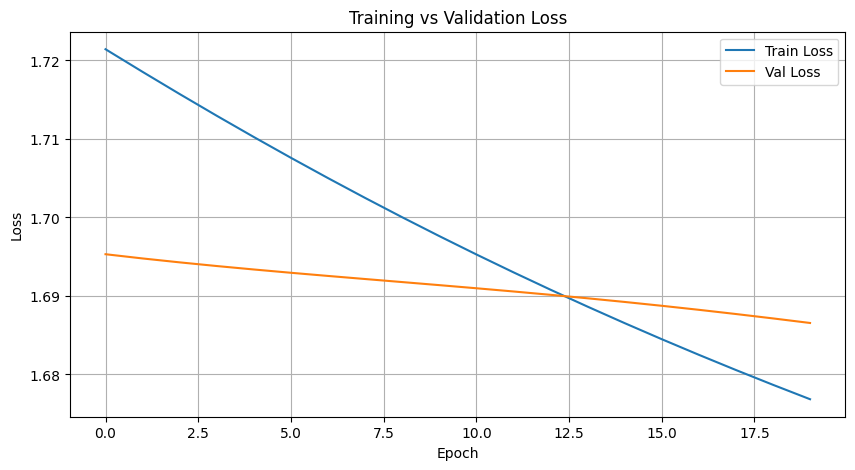

In [ ]:
# Initialize model
concept_names = [keywords, abstract_concepts, labels]
model = ConceptNetwork(concept_names, embedding_dim=32)  # Reduced embedding dim for speed

# Train
train_losses, val_losses = train_model(
    model, train_texts, train_labels, train_keyword_scores, train_abstract_scores,
    val_texts, val_labels, val_keyword_scores, val_abstract_scores,
    concept_names, sbert_embeddings, batch_size=32, num_epochs=50,
    patience=5, lambda_semantic=0.1, device=device
)


In [34]:
# Load best model
model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

In [35]:
# Test
test_model(model, test_keyword_scores, test_abstract_scores, test_labels, concept_names, batch_size=32, device=device)

Testing: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Classification Report:
                                 precision    recall  f1-score   support

        cardiovascular diseases       0.00      0.00      0.00         1
      digestive system diseases       0.00      0.00      0.00         1
general pathological conditions       0.00      0.00      0.00         1
                      neoplasms       0.00      0.00      0.00         1
        nervous system diseases       0.20      1.00      0.33         1

                       accuracy                           0.20         5
                      macro avg       0.04      0.20      0.07         5
                   weighted avg       0.04      0.20      0.07         5




Interpretable Prediction for Sample:
Input Text: Noninvasive measurement of renal blood flow with technetium-99m-DTPA in the evaluation of patients with suspected renovascular hypertension If a hypertensive patient with renal artery stenosis (RAS) is to benefit from percutaneous transluminal renal angioplasty (PTRA) in terms of a sustained improvement in blood pressure control, one may postulate a demonstrable reduction in renal blood flow (RBF) to that kidney, reversible by PTRA. In a population of 32 hypertensive patients, RAS was present in 23 of 62 kidneys. Eleven of the 32 patients underwent renal revascularization, of whom 6 showed improvement in blood pressure control at 6 mo, i.e., had renovascular hypertension (RVH). There was no correlation between RBF and angiographic appearances of the renal artery. Furthermore, there was no significant difference between RBF in the stenosed kidneys of the patients with RVH compared with the stenosed kidneys of patients without RVH. Indivi

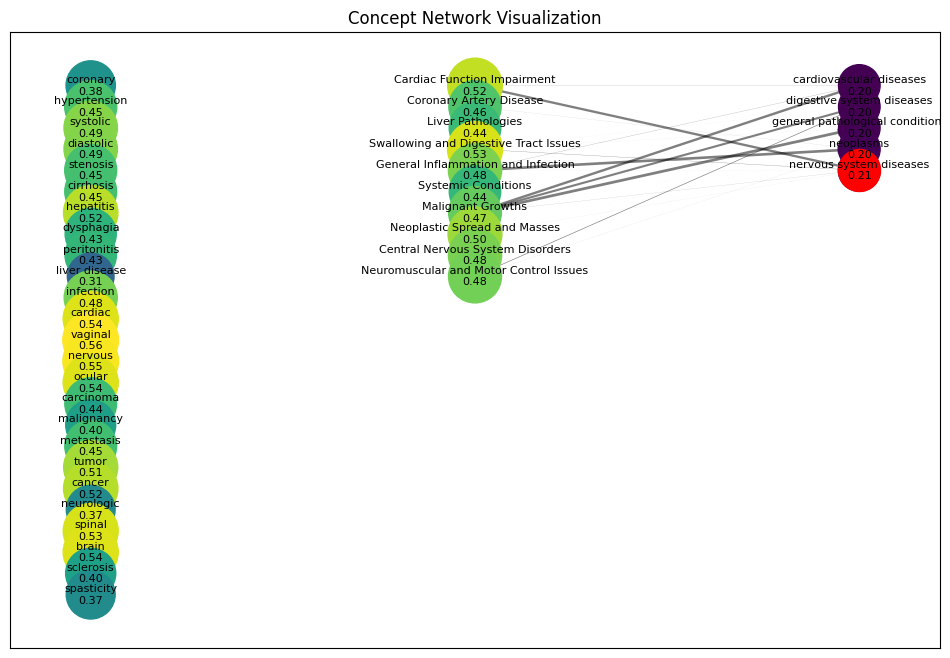

In [36]:
# Interpretable prediction
if test_texts and test_labels:
    keyword_scores, abstract_scores, label_probs, predicted_label_idx = interpretable_prediction(
        model, test_texts[0], test_labels[0], test_keyword_scores, test_abstract_scores, concept_names, device=device
    )
    visualize_network(model, concept_names, keyword_scores, abstract_scores, label_probs, predicted_label_idx)